## Regression task
### import necessary libraries

In [902]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from category_encoders import OneHotEncoder
from ydata_profiling import ProfileReport
from sklearn.metrics import mean_squared_error, mean_absolute_error


### data extraction and EDA

In [903]:
couriers_data = pd.read_json("couriers_data.json")
couriers_data.head()

courier_id courier_transport  total_deliveries  max_unique_pickups  \
0        6463        automobile                 2                   2   
1        6463        automobile                12                   9   
2        6463        automobile                 7                   7   
3        6463        automobile                 3                   1   
4        7717        automobile                 4                   4   

                work_start              work_finish  late_pickups(%)  \
0  2023-09-05T20:50:08.000  2023-09-05T22:17:19.000         0.000000   
1  2023-09-06T12:39:25.000  2023-09-06T23:37:54.000         0.000000   
2  2023-09-07T00:15:32.000  2023-09-07T21:53:54.000         0.142857   
3  2023-09-09T11:53:46.000  2023-09-09T12:04:32.000         0.000000   
4  2023-09-04T12:12:53.000  2023-09-04T13:22:41.000         0.000000   

   late_deliveries(%)  
0            0.000000  
1            0.250000  
2            0.285714  
3            0.000000  
4            0.000000

In [904]:
couriers_data.describe().transpose()

count          mean            std     min        25%  \
courier_id          11772.0  1.722670e+06  773419.651703  6463.0  1535845.0   
total_deliveries    11772.0  9.120031e+00       6.079818     2.0        4.0   
max_unique_pickups  11772.0  6.707356e+00       4.453718     1.0        3.0   
late_pickups(%)     11772.0  7.162498e-02       0.134943     0.0        0.0   
late_deliveries(%)  11772.0  1.100736e-01       0.174954     0.0        0.0   

                          50%           75%        max  
courier_id          2002573.0  2.355939e+06  2509933.0  
total_deliveries          8.0  1.300000e+01       42.0  
max_unique_pickups        6.0  9.000000e+00       30.0  
late_pickups(%)           0.0  1.000000e-01        1.0  
late_deliveries(%)        0.0  1.666667e-01        1.0

In [905]:
couriers_profile_report = ProfileReport(couriers_data)
couriers_profile_report.to_file("couriers_data.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Profiling report review

From the porfiling report, we can see that data is highly imbalanced on courier_transport feature. It's better to remove a samples with 'foot' values.

Also there's a high percentage(average or slighly above) of zeroes on 'late_pickups' and 'late_delievries', we'll try to impute the data.

### Lets check data distribution

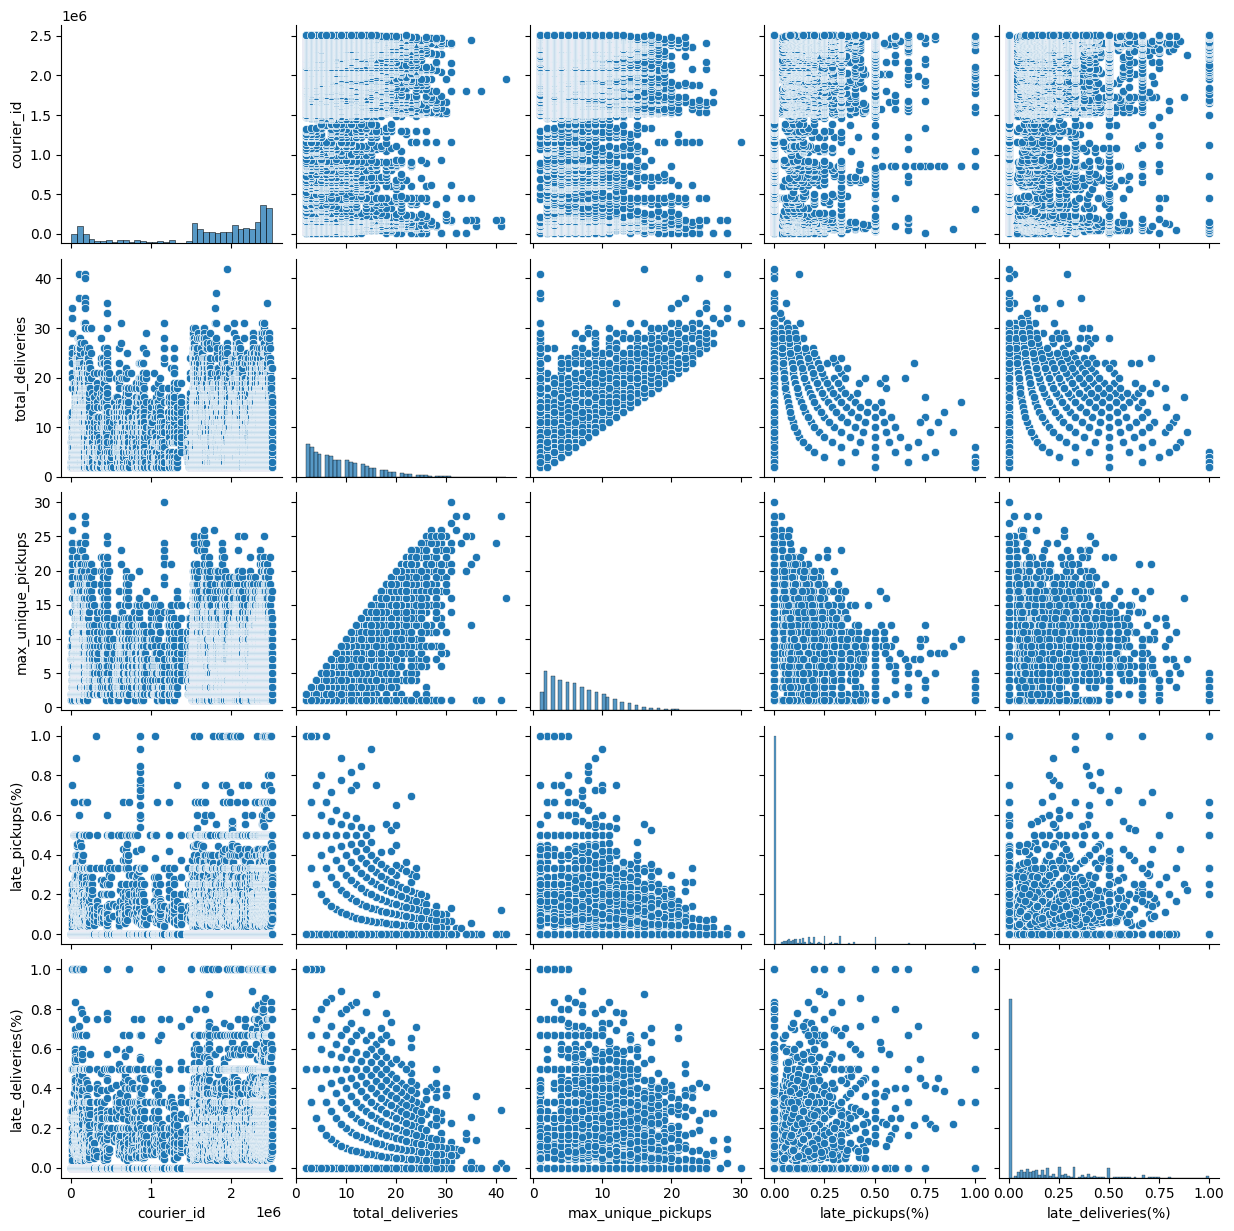

In [906]:
sns.pairplot(couriers_data)

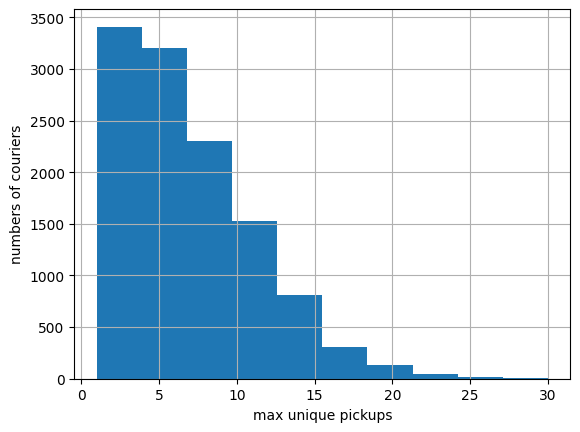

In [907]:
couriers_data["max_unique_pickups"].hist()

plt.xlabel("max unique pickups")
plt.ylabel("numbers of couriers")

plt.show()

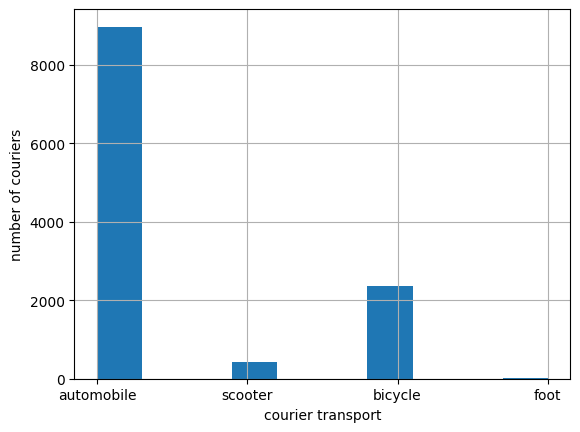

In [908]:
couriers_data["courier_transport"].hist()

plt.xlabel("courier transport")
plt.ylabel("number of couriers")

plt.show()

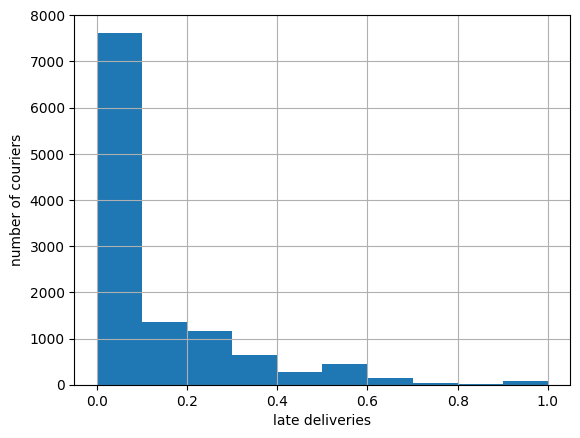

In [909]:
couriers_data["late_deliveries(%)"].hist()

plt.xlabel("late deliveries")
plt.ylabel("number of couriers")

plt.show()

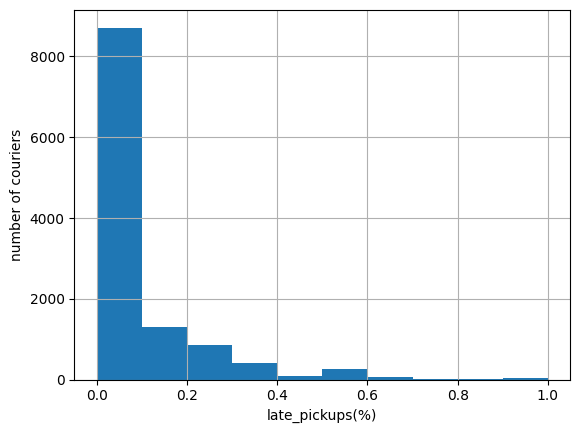

In [910]:
couriers_data["late_pickups(%)"].hist()

plt.xlabel("late_pickups(%)")
plt.ylabel("number of couriers")

plt.show()

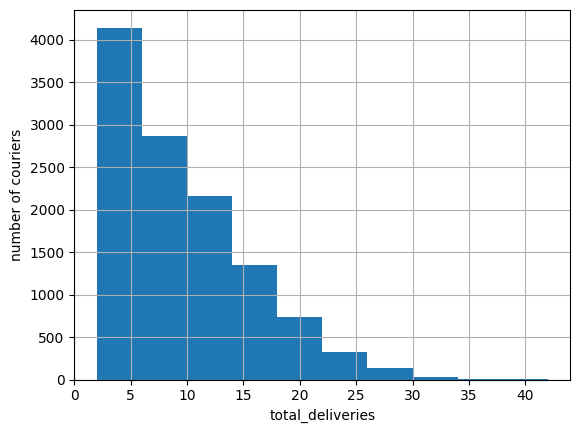

In [911]:
couriers_data["total_deliveries"].hist()

plt.xlabel("total_deliveries")
plt.ylabel("number of couriers")

plt.show()

In [912]:
couriers_data["total_deliveries"].describe()

count    11772.000000
mean         9.120031
std          6.079818
min          2.000000
25%          4.000000
50%          8.000000
75%         13.000000
max         42.000000
Name: total_deliveries, dtype: float64

### replace 'work_start' and 'work_finish' features, by defining a new one as difference of these as 'hours_engaged'
### encoding 'courier_transport' feature
### defining the target variable

In [913]:
couriers_pr_data = couriers_data
couriers_pr_data["hours_engaged"] = pd.to_datetime(couriers_data["work_finish"]).dt.hour - pd.to_datetime(couriers_pr_data["work_start"]).dt.hour
couriers_pr_data = couriers_data.drop(["courier_id", "work_finish", "work_start"], axis=1)



Let's check again the most imbalanced feature

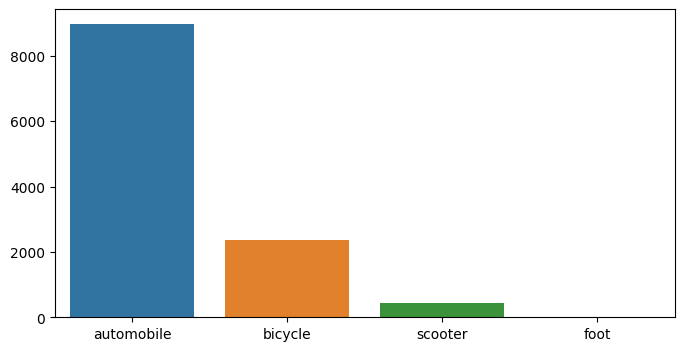

In [914]:
%matplotlib inline

data_group = couriers_pr_data['courier_transport'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=data_group.index, y=data_group.values)
plt.show()

In [915]:
couriers_on_foot = couriers_data[couriers_data["courier_transport"] == "foot"]
couriers_on_foot_num = couriers_on_foot.count()
print(f"Number of samples, where courier delivered on foot: {couriers_on_foot_num[0]}")

Number of samples, where courier delivered on foot: 6


There's only 6 samples out of almost 12000 where couriers delivered orders by foot.
This data should be removed.

In [916]:
couriers_pr_data = couriers_pr_data.drop(couriers_on_foot.index, axis=0)
y = couriers_pr_data["total_deliveries"]
couriers_pr_data.drop(["total_deliveries"], axis=1, inplace=True)
couriers_pr_data.head()

courier_transport  max_unique_pickups  late_pickups(%)  late_deliveries(%)  \
0        automobile                   2         0.000000            0.000000   
1        automobile                   9         0.000000            0.250000   
2        automobile                   7         0.142857            0.285714   
3        automobile                   1         0.000000            0.000000   
4        automobile                   4         0.000000            0.000000   

   hours_engaged  
0              2  
1             11  
2             21  
3              1  
4              1

Encode courier_transport feature using OneHotEncoder and 
scale data using StandardScaler

In [917]:
ohe = OneHotEncoder()
couriers_enc_columns = ohe.fit_transform(couriers_pr_data["courier_transport"])
couriers_pr_data[couriers_enc_columns.columns] = couriers_enc_columns

couriers_pr_data.drop(["courier_transport"], axis=1, inplace=True)
couriers_pr_data.describe()


max_unique_pickups  late_pickups(%)  late_deliveries(%)  hours_engaged  \
count        11766.000000     11766.000000        11766.000000   11766.000000   
mean             6.708737         0.071662            0.110028       7.798997   
std              4.454262         0.134968            0.174945       6.394601   
min              1.000000         0.000000            0.000000       0.000000   
25%              3.000000         0.000000            0.000000       3.000000   
50%              6.000000         0.000000            0.000000       7.000000   
75%              9.000000         0.100000            0.166667      10.000000   
max             30.000000         1.000000            1.000000      23.000000   

       courier_transport_1  courier_transport_2  courier_transport_3  
count         11766.000000         11766.000000         11766.000000  
mean              0.762536             0.036631             0.200833  
std               0.425547             0.187862             0.400640  
min               0.000000             0.000000             0.000000  
25%               1.000000             0.000000             0.000000  
50%               1.000000             0.000000             0.000000  
75%               1.000000             0.000000             0.000000  
max               1.000000             1.000000             1.000000

In [918]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(couriers_pr_data), columns=couriers_pr_data.columns)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8)

linear_regression = LinearRegression()

linear_regression.fit(x_train, y_train)
y_val_pred = linear_regression.predict(x_val)

print(f"MSE on validation set: {mean_squared_error(y_val_pred, y_val)}")
print(f"RMSE on validation set: {np.sqrt(mean_squared_error(y_val_pred, y_val))}")
print(f"MAE on validation set: {mean_absolute_error(y_val_pred, y_val)}")
print()
print()

y_pred = linear_regression.predict(x_test)


print(f"MSE: {mean_squared_error(y_pred, y_test)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_pred, y_test))}")
print(f"MAE: {mean_absolute_error(y_pred, y_test)}")

X.describe().T

MSE on validation set: 12.429588207165525
RMSE on validation set: 3.5255621122262935
MAE on validation set: 2.341140128501564


MSE: 11.674844046181219
RMSE: 3.4168470914252542
MAE: 2.2617219918227716


count          mean       std       min       25%  \
max_unique_pickups   11766.0  5.072717e-17  1.000042 -1.281689 -0.832662   
late_pickups(%)      11766.0  1.062855e-16  1.000042 -0.530976 -0.530976   
late_deliveries(%)   11766.0 -5.314275e-17  1.000042 -0.628955 -0.628955   
hours_engaged        11766.0  7.850634e-18  1.000042 -1.219674 -0.750508   
courier_transport_1  11766.0 -1.352725e-16  1.000042 -1.791973  0.558044   
courier_transport_2  11766.0  1.932464e-17  1.000042 -0.194997 -0.194997   
courier_transport_3  11766.0  7.729855e-17  1.000042 -0.501301 -0.501301   

                          50%       75%       max  
max_unique_pickups  -0.159121  0.514420  5.229206  
late_pickups(%)     -0.530976  0.209974  6.878525  
late_deliveries(%)  -0.628955  0.323767  5.087380  
hours_engaged       -0.124954  0.344212  2.377263  
courier_transport_1  0.558044  0.558044  0.558044  
courier_transport_2 -0.194997 -0.194997  5.128285  
courier_transport_3 -0.501301 -0.501301  1.994809

In [919]:
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(couriers_pr_data), columns=couriers_pr_data.columns)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8)

linear_regression = LinearRegression()

linear_regression.fit(x_train, y_train)
y_val_pred = linear_regression.predict(x_val)

print(f"MSE on validation set: {mean_squared_error(y_val_pred, y_val)}")
print(f"RMSE on validation set: {np.sqrt(mean_squared_error(y_val_pred, y_val))}")
print(f"MAE on validation set: {mean_absolute_error(y_val_pred, y_val)}")
print()
print()

y_pred = linear_regression.predict(x_test)


print(f"MSE: {mean_squared_error(y_pred, y_test)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_pred, y_test))}")
print(f"MAE: {mean_absolute_error(y_pred, y_test)}")

X.describe().T

MSE on validation set: 11.530636031802175
RMSE on validation set: 3.3956790236714327
MAE on validation set: 2.291270756157665


MSE: 11.781231508729178
RMSE: 3.432379860785979
MAE: 2.2695366832033197


count      mean       std       min       25%  50%  \
max_unique_pickups   11766.0  0.118123  0.742377 -0.833333 -0.500000  0.0   
late_pickups(%)      11766.0  0.716615  1.349676  0.000000  0.000000  0.0   
late_deliveries(%)   11766.0  0.660166  1.049668  0.000000  0.000000  0.0   
hours_engaged        11766.0  0.114142  0.913514 -1.000000 -0.571429  0.0   
courier_transport_1  11766.0 -0.237464  0.425547 -1.000000  0.000000  0.0   
courier_transport_2  11766.0  0.036631  0.187862  0.000000  0.000000  0.0   
courier_transport_3  11766.0  0.200833  0.400640  0.000000  0.000000  0.0   

                          75%        max  
max_unique_pickups   0.500000   4.000000  
late_pickups(%)      1.000000  10.000000  
late_deliveries(%)   1.000000   6.000000  
hours_engaged        0.428571   2.285714  
courier_transport_1  0.000000   0.000000  
courier_transport_2  0.000000   1.000000  
courier_transport_3  0.000000   1.000000

#### Let's try to slightly improve the prediction by changing the scaler to MinMaxScaler or trying another regression model


In [920]:
mmx_scaler = MinMaxScaler()
X = pd.DataFrame(mmx_scaler.fit_transform(couriers_pr_data), columns=couriers_pr_data.columns)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8)

linear_regression_mmsc = LinearRegression()

linear_regression_mmsc.fit(x_train, y_train)
y_val_pred = linear_regression_mmsc.predict(x_val)

print(f"MSE on validation set: {mean_squared_error(y_val_pred, y_val)}")
print(f"RMSE on validation set: {np.sqrt(mean_squared_error(y_val_pred, y_val))}")
print(f"MAE on validation set: {mean_absolute_error(y_val_pred, y_val)}")
print()
print()


y_pred = linear_regression_mmsc.predict(x_test)


print(f"MSE: {mean_squared_error(y_pred, y_test)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_pred, y_test))}")
print(f"MAE: {mean_absolute_error(y_pred, y_test)}")

X.describe().T

MSE on validation set: 13.057720744463495
RMSE on validation set: 3.613546837175837
MAE on validation set: 2.3906628083687442


MSE: 11.531626679478
RMSE: 3.3958248894013954
MAE: 2.239393054375531


count      mean       std  min       25%       50%  \
max_unique_pickups   11766.0  0.196853  0.153595  0.0  0.068966  0.172414   
late_pickups(%)      11766.0  0.071662  0.134968  0.0  0.000000  0.000000   
late_deliveries(%)   11766.0  0.110028  0.174945  0.0  0.000000  0.000000   
hours_engaged        11766.0  0.339087  0.278026  0.0  0.130435  0.304348   
courier_transport_1  11766.0  0.762536  0.425547  0.0  1.000000  1.000000   
courier_transport_2  11766.0  0.036631  0.187862  0.0  0.000000  0.000000   
courier_transport_3  11766.0  0.200833  0.400640  0.0  0.000000  0.000000   

                          75%  max  
max_unique_pickups   0.275862  1.0  
late_pickups(%)      0.100000  1.0  
late_deliveries(%)   0.166667  1.0  
hours_engaged        0.434783  1.0  
courier_transport_1  1.000000  1.0  
courier_transport_2  0.000000  1.0  
courier_transport_3  0.000000  1.0

#### Lets check the performance of different regression algorithms

In this case we will check how good the Lasso regression is on our data, and try to compute the best alpha

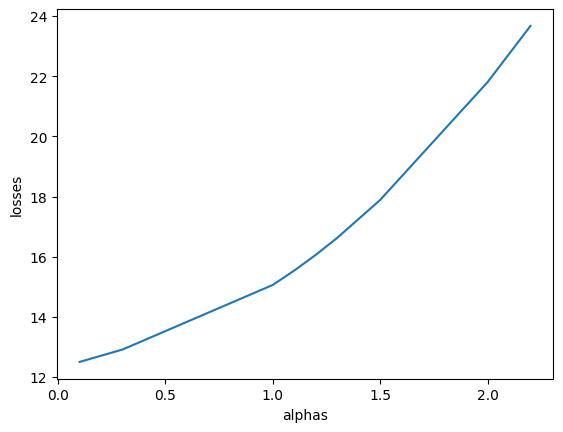

MSE on validation set: 15.063434490406015
RMSE on validation set: 3.8811640638352323
MAE on validation set: 2.823380649893896


MSE: 14.746519073698972
RMSE: 3.8401196691898773
MAE: 2.4396894270113454


In [929]:

scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(couriers_pr_data), columns=couriers_pr_data.columns)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8)

lasso = Lasso()

lasso.fit(x_train, y_train)
ridge.fit(x_train, y_train)
y_val_pred = lasso.predict(x_val)

# print(f"lasso.coef_: {lasso.coef_}")
# print(f"lasso.coef_: {ridge.coef_}")

alphas = [2.2, 2, 1.5, 1.3, 1.2, 1.1, 1, 0.3, 0.1]
losses = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)
    y_pred = lasso.predict(x_val)
    mse = mean_squared_error(y_pred, y_val)
    losses.append(mse)

plb.plot(alphas, losses)
plb.xlabel("alphas")
plb.ylabel("losses")
plb.show()

print(f"MSE on validation set: {mean_squared_error(y_val_pred, y_val)}")
print(f"RMSE on validation set: {np.sqrt(mean_squared_error(y_val_pred, y_val))}")
print(f"MAE on validation set: {mean_absolute_error(y_val_pred, y_val)}")
print()
print()


y_pred = lasso.predict(x_test)


print(f"MSE: {mean_squared_error(y_pred, y_test)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_pred, y_test))}")
print(f"MAE: {mean_absolute_error(y_pred, y_test)}")



# X.describe().T
# print(lasso.coef_)

In [936]:
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(couriers_pr_data), columns=couriers_pr_data.columns)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8)

ridge = Ridge()

ridge.fit(x_train, y_train)
y_val_pred = ridge.predict(x_val)


print(f"MSE on validation set: {mean_squared_error(y_val_pred, y_val)}")
print(f"RMSE on validation set: {np.sqrt(mean_squared_error(y_val_pred, y_val))}")
print(f"MAE on validation set: {mean_absolute_error(y_val_pred, y_val)}")
print()
print()


y_pred = lasso.predict(x_test)


print(f"MSE: {mean_squared_error(y_pred, y_test)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_pred, y_test))}")
print(f"MAE: {mean_absolute_error(y_pred, y_test)}")



MSE on validation set: 12.514735472796822
RMSE on validation set: 3.5376172026940425
MAE on validation set: 2.3139643490740447


MSE: 12.431680245680445
RMSE: 3.525858795482378
MAE: 2.3071001755933893


In [ ]:
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(couriers_pr_data), columns=couriers_pr_data.columns)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8)

lasso = Lasso()

lasso.fit(x_train, y_train)
ridge.fit(x_train, y_train)
y_val_pred = lasso.predict(x_val)


In [922]:

scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(couriers_pr_data), columns=couriers_pr_data.columns)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8)

lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_val)
mse = mean_squared_error(y_pred, y_val)
losses.append(mse)

print(f"MSE on validation set: {mean_squared_error(y_val_pred, y_val)}")
print(f"RMSE on validation set: {np.sqrt(mean_squared_error(y_val_pred, y_val))}")
print(f"MAE on validation set: {mean_absolute_error(y_val_pred, y_val)}")
print()
print()


y_pred = lasso.predict(x_test)


print(f"MSE: {mean_squared_error(y_pred, y_test)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_pred, y_test))}")
print(f"MAE: {mean_absolute_error(y_pred, y_test)}")




MSE on validation set: 47.43511233514981
RMSE on validation set: 6.887315321309879
MAE on validation set: 5.485526557344369


MSE: 13.724366753080202
RMSE: 3.7046412448549186
MAE: 2.3653648533400107


#### Let's check the performance of the svr(Support vector regression)

In [927]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(couriers_pr_data), columns=couriers_pr_data.columns)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8)

svr = SVR()

svr.fit(x_train, y_train)
y_val_pred = svr.predict(x_val)

print(f"MSE on validation set: {mean_squared_error(y_val_pred, y_val)}")
print(f"RMSE on validation set: {np.sqrt(mean_squared_error(y_val_pred, y_val))}")
print(f"MAE on validation set: {mean_absolute_error(y_val_pred, y_val)}")
print()
print()


y_pred = svr.predict(x_test)


print(f"MSE: {mean_squared_error(y_pred, y_test)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_pred, y_test))}")
print(f"MAE: {mean_absolute_error(y_pred, y_test)}")

MSE on validation set: 11.26779992744031
RMSE on validation set: 3.3567543740107513
MAE on validation set: 1.9298812498688265


MSE: 9.78750741250839
RMSE: 3.1284992268671554
MAE: 1.8736379695510232


As we can see the best performance were shown by the SVR model